In [1]:
!pip install kaggle # chack instlaition of kaggle


In [2]:
!mkdir ~/.kaggle # make new folder (kaggle)


In [3]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json # make file to my folder

In [5]:
!kaggle datasets list # make connection

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                 DAIGT V2 Train Dataset                               29MB  2023-11-16 01:38:36           1590        161  1.0              
muhammadbinimran/housing-price-prediction-data                  Housing Price Prediction Data                       763KB  2023-11-21 17:56:32           7116        128  1.0              
thedevastator/netflix-imdb-scores                               Netflix IMDB Scores                                 699KB  2023-12-03 14:10:34           2365         42  1.0              
thedevastator/spotify-tracks-genre-dataset                  

In [6]:
!kaggle datasets download -d msambare/fer2013

 60% 36.0M/60.3M [00:00<00:00, 122MB/s]
100% 60.3M/60.3M [00:00<00:00, 153MB/s]


In [7]:
!unzip /content/fer2013.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import os
from skimage import io, color, feature, exposure
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.models import load_model
from skimage import color
import warnings
warnings.filterwarnings('ignore')

In [9]:
def extract_hog_features(image):
    if len(image.shape) == 3 and image.shape[-1] == 3:
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image

    hog_features, hog_image = feature.hog(gray_image, visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return hog_features, hog_image_rescaled

In [10]:
train_path = 'train'
test_path = 'test'

In [11]:
class_folders_train = [os.path.join(train_path, f) for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))]
class_folders_test = [os.path.join(test_path, f) for f in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, f))]

In [12]:
def process_data(class_folders, features_list, labels_list):
    for class_folder in class_folders:
        class_name = os.path.basename(class_folder)

        for image_filename in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_filename)
            image = io.imread(image_path)

            hog_features, hog_image = extract_hog_features(image)

            features_list.append(hog_features)
            labels_list.append(class_name)




In [13]:
train_features_list = []
train_labels_list = []
test_features_list = []
test_labels_list = []

process_data(class_folders_train, train_features_list, train_labels_list)
process_data(class_folders_test, test_features_list, test_labels_list)

In [15]:
train_features_array = np.array(train_features_list)
train_labels_array = np.array(train_labels_list)
test_features_array = np.array(test_features_list)
test_labels_array = np.array(test_labels_list)

In [16]:
train_features_array=train_features_array /225.0
test_features_array=test_features_array /225.0

In [17]:
label_encoder = LabelEncoder()
train_numeric_labels = label_encoder.fit_transform(train_labels_array)
test_numeric_labels = label_encoder.transform(test_labels_array)

In [18]:
train_features_array = train_features_array.reshape(-1, train_features_array.shape[1])
test_features_array = test_features_array.reshape(-1, test_features_array.shape[1])

In [ ]:
train_features_array.shape[1]

1296

In [23]:
from keras.models import Sequential
modelq = Sequential()
modelq.add(Dense(32, input_shape=(train_features_array.shape[1],), activation='relu'))
modelq.add(Dropout(0.4))
modelq.add(Dense(128, activation='relu'))
modelq.add(Dropout(0.6))
modelq.add(Dense(512, activation='relu'))
modelq.add(Flatten())
modelq.add(Dense(7, activation='softmax'))

modelq.summary()

modelq.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = modelq.fit(train_features_array, train_numeric_labels, epochs=350)

modelq.save('ANN(HOG).h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                41504     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 128)               4224      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               66048     
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 7)                

In [24]:
y_pred = modelq.predict(test_features_array)
test_loss, test_acc = modelq.evaluate(test_features_array, test_numeric_labels)
print("Test accuracy {0:.2f}% ". format( 100*test_acc))

225/225 [==============================] - 1s 2ms/step - loss: 1.4636 - accuracy: 0.4411
Test accuracy 44.11% 


In [25]:
from sklearn.metrics import classification_report
y_pred_classes = np.argmax(y_pred, axis=1)
class_report = classification_report(test_numeric_labels, y_pred_classes)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.16      0.22       958
           1       0.00      0.00      0.00       111
           2       0.28      0.07      0.11      1024
           3       0.59      0.76      0.67      1774
           4       0.36      0.48      0.41      1233
           5       0.30      0.43      0.35      1247
           6       0.59      0.56      0.58       831

    accuracy                           0.44      7178
   macro avg       0.35      0.35      0.33      7178
weighted avg       0.41      0.44      0.41      7178



In [26]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_numeric_labels, np.argmax(y_pred, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 151    0   38  201  214  316   38]
 [  38    0    5   19   17   28    4]
 [  90    0   71  177  249  272  165]
 [  31    0   18 1352  102  235   36]
 [  43    0   29  199  588  328   46]
 [  65    0   45  226  340  535   36]
 [  23    0   51  113  102   73  469]]


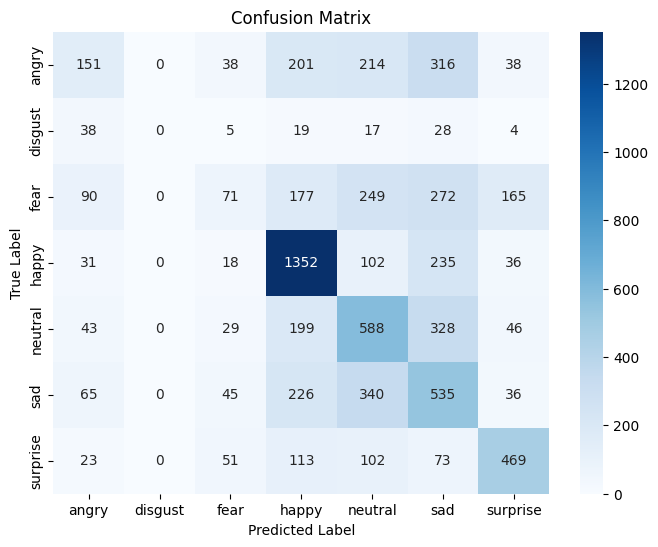

In [27]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

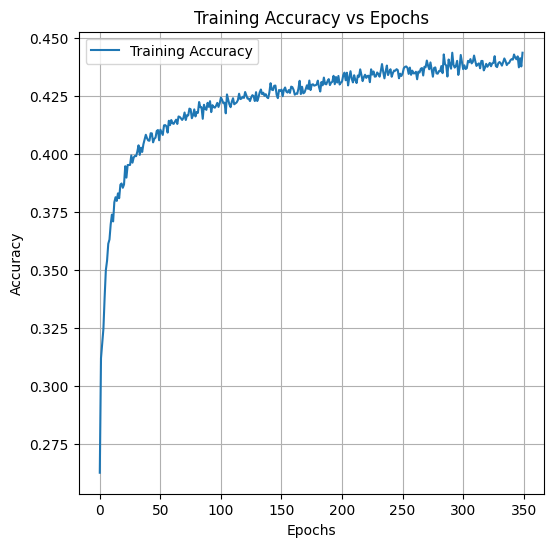

In [28]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

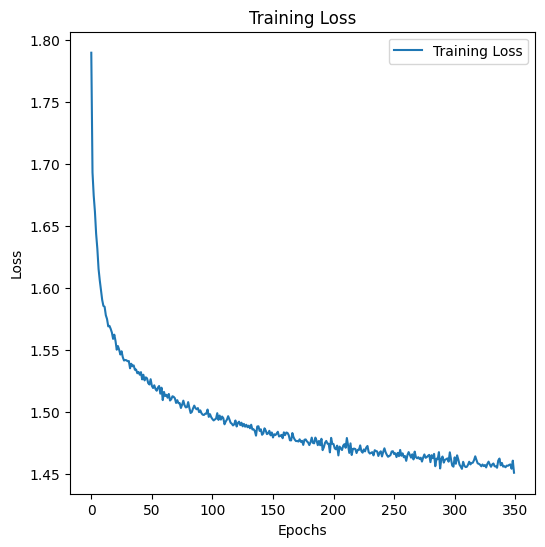

In [29]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()